# Edge AI Model Compression: Quantization Techniques on EfficientNet V2

This notebook implements comprehensive quantization techniques for EfficientNet V2 models on the real ImageNet-1k validation dataset.

## Objectives:
- Implement multiple quantization techniques (baseline, dynamic, float16, int8)
- Evaluate model performance and size reduction
- Compare quantization methods on ImageNet-1k validation dataset
- Optimize for edge deployment scenarios

## Dataset:
- **ImageNet-1k validation** (50,000 images)
- Loaded from a local `val` directory if present, otherwise downloaded via kagglehub (`titericz/imagenet1k-val`)


In [2]:
# # ================================
# # INSTALL REQUIRED PACKAGES ()
# # ================================

# # Use the working approach from QuantizationTechniques.ipynb
# !pip install keras
# !pip install tensorflow
# !pip install tensorflow-model-optimization
# !pip install kagglehub --quiet

# print("📦 Required packages installed successfully!")


In [3]:
# ================================
# COLAB ENVIRONMENT SETUP ()
# ================================

import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json

# Simple, robust setup like the working notebook
print("🔧 Setting up Colab environment...")
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

print("🚀 Environment setup complete!")


🔧 Setting up Colab environment...
TensorFlow version: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
🚀 Environment setup complete!


In [7]:
# ================================
# IMAGENET-1K VALIDATION DATASET SETUP (LOCAL OR KAGGLE)
# ================================

import kagglehub
import glob
from PIL import Image
import sys

IMG_SIZE = 224
BATCH_SIZE = 32
MAX_SAMPLES = 50000  # ImageNet val has 50k images; can cap later



print("🔐 Setting up Kaggle authentication for ImageNet-1k validation...")
if 'kaggle.json' not in os.listdir():
    sys.exit("Add kaggle.json to access the dataset from Kaggle or place a local 'val' folder next to the notebook")

print("📁 Downloading ImageNet-1k validation dataset from Kaggle...")
try:
    # Prefer curated ImageNet1k val split packaged by community
    path = kagglehub.dataset_download("titericz/imagenet1k-val")
    IMAGENET_PATH = path
    print("✅ Dataset downloaded successfully!")
    print(f"Dataset path: {IMAGENET_PATH}")
except Exception as e:
    print(f"❌ Error downloading dataset: {e}")
    IMAGENET_PATH = None

print(f"Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Batch size: {BATCH_SIZE}")


🔐 Setting up Kaggle authentication for ImageNet-1k validation...
📁 Downloading ImageNet-1k validation dataset from Kaggle...
Using Colab cache for faster access to the 'imagenet1k-val' dataset.
✅ Dataset downloaded successfully!
Dataset path: /kaggle/input/imagenet1k-val
Image size: 224x224
Batch size: 32


In [4]:
!ls /root/.cache/kagglehub/datasets/titericz/imagenet1k-val/versions/1/imagenet-val

dataset-metadata.json  n02089867  n02342885  n03042490	n03787032  n04350905
n01440764	       n02089973  n02346627  n03045698	n03788195  n04355338
n01443537	       n02090379  n02356798  n03047690	n03788365  n04355933
n01484850	       n02090622  n02361337  n03062245	n03791053  n04356056
n01491361	       n02090721  n02363005  n03063599	n03792782  n04357314
n01494475	       n02091032  n02364673  n03063689	n03792972  n04366367
n01496331	       n02091134  n02389026  n03065424	n03793489  n04367480
n01498041	       n02091244  n02391049  n03075370	n03794056  n04370456
n01514668	       n02091467  n02395406  n03085013	n03796401  n04371430
n01514859	       n02091635  n02396427  n03089624	n03803284  n04371774
n01518878	       n02091831  n02397096  n03095699	n03804744  n04372370
n01530575	       n02092002  n02398521  n03100240	n03814639  n04376876
n01531178	       n02092339  n02403003  n03109150	n03814906  n04380533
n01532829	       n02093256  n02408429  n03110669	n03825788  n04389033
n01534433	    

In [8]:
# ================================
# DATASET LOADING
# ================================

def load_imagenet_val_dataset(imagenet_path, img_size=224, batch_size=32, max_samples=None):
    """Load ImageNet-1k validation dataset with proper preprocessing."""
    print(f"📁 Loading ImageNet-1k validation samples from: {imagenet_path}")

    val_dir = os.path.join(imagenet_path, "imagenet-val")
    if not os.path.exists(val_dir):
        raise FileNotFoundError(f"❌ Validation folder not found at {val_dir}")

    dataset = tf.keras.utils.image_dataset_from_directory(
        val_dir,
        labels="inferred",
        label_mode="int",
        image_size=(img_size, img_size),
        batch_size=batch_size,
        shuffle=False
    )

    # Get total count before limiting
    total_samples = tf.data.experimental.cardinality(dataset).numpy() * batch_size

    # Optionally cap dataset
    if max_samples:
        dataset = dataset.unbatch().take(max_samples).batch(batch_size)
        total_samples = min(total_samples, max_samples)

    # Preprocess with EfficientNet normalization
    def preprocess(image, label):
        # EfficientNetV2 expects values in [0, 255] actually!
        # preprocess_input will normalize them internally
        image = tf.cast(image, tf.float32)  # Ensure float32
        image = tf.keras.applications.efficientnet_v2.preprocess_input(image)
        return image, label

    dataset = dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    print(f"✅ Dataset ready with {total_samples} samples!")
    return dataset


In [9]:
# ================================
# LOAD AND VERIFY
# ================================

if IMAGENET_PATH:
    print("🔄 Loading ImageNet-1k validation dataset...")
    dataset = load_imagenet_val_dataset(IMAGENET_PATH, IMG_SIZE, BATCH_SIZE, MAX_SAMPLES)

    if dataset:
        try:
            print("🧪 Testing dataset with one batch...")
            sample_batch, sample_labels = next(iter(dataset))
            print(f"✅ Sample batch shape: {sample_batch.shape}")
            print(f"🧾 Sample labels shape: {sample_labels.shape}")
            print(f"🎨 Pixel range: [{sample_batch.numpy().min():.3f}, {sample_batch.numpy().max():.3f}]")
            print("✅ ImageNet-1k validation dataset is ready for evaluation!")
            DATASET_AVAILABLE = True
        except Exception as e:
            print(f"❌ Error testing dataset: {e}")
            DATASET_AVAILABLE = False
    else:
        print("❌ Could not load dataset properly.")
        DATASET_AVAILABLE = False
else:
    print("❌ ImageNet-1k validation dataset not available")
    DATASET_AVAILABLE = False

🔄 Loading ImageNet-1k validation dataset...
📁 Loading ImageNet-1k validation samples from: /kaggle/input/imagenet1k-val
Found 50000 files belonging to 1000 classes.
✅ Dataset ready with 50000 samples!
🧪 Testing dataset with one batch...
✅ Sample batch shape: (32, 224, 224, 3)
🧾 Sample labels shape: (32,)
🎨 Pixel range: [0.000, 255.000]
✅ ImageNet-1k validation dataset is ready for evaluation!


In [10]:
# ================================
# LOAD EFFICIENTNET MODEL ()
# ================================

print("🤖 Loading EfficientNetV2B0 model...")

# Load EfficientNetV2B0 pretrained on ImageNet
model = tf.keras.applications.EfficientNetV2B0(
    weights="imagenet",
    input_shape=(224, 224, 3),
    include_top=True
)

print(f"✅ Model loaded successfully!")
print(f"Model input shape: {model.input_shape}")
print(f"Model output shape: {model.output_shape}")
print(f"Total parameters: {model.count_params():,}")


🤖 Loading EfficientNetV2B0 model...
✅ Model loaded successfully!
Model input shape: (None, 224, 224, 3)
Model output shape: (None, 1000)
Total parameters: 7,200,312


## 1. Baseline Model (No Quantization)


In [11]:
# ================================
# BASELINE MODEL (NO QUANTIZATION)
# ================================

print("📊 Creating baseline TFLite model (no quantization)...")

# Use the working approach from QuantizationTechniques.ipynb
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("efficientnetv2_b0_baseline.tflite", "wb") as f:
    f.write(tflite_model)

baseline_size = os.path.getsize("efficientnetv2_b0_baseline.tflite") / 1024
print(f"✅ Baseline model saved: {baseline_size:.2f} KB")

# Store results
results = {
    "Baseline": {
        "size_kb": baseline_size,
        "file": "efficientnetv2_b0_baseline.tflite"
    }
}


📊 Creating baseline TFLite model (no quantization)...
Saved artifact at '/tmp/tmpo6hy2e9m'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1000), dtype=tf.float32, name=None)
Captures:
  137457986382608: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  137457986382416: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  137457986382992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137457986384144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137457986383376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137457986382032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137457986385104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137457986373968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137457986383184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137457986

## 2. Dynamic Range Quantization


In [12]:
# ================================
# DYNAMIC RANGE QUANTIZATION
# ================================

print("⚡ Creating dynamic range quantized model...")

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model_dynamic = converter.convert()
with open("efficientnetv2_b0_dynamic.tflite", "wb") as f:
    f.write(tflite_model_dynamic)

dynamic_size = os.path.getsize("efficientnetv2_b0_dynamic.tflite") / 1024
print(f"✅ Dynamic quantized model saved: {dynamic_size:.2f} KB")

# Calculate compression ratio
compression_ratio = (baseline_size - dynamic_size) / baseline_size * 100
print(f"📉 Size reduction: {compression_ratio:.1f}%")

# Store results
results["Dynamic Range"] = {
    "size_kb": dynamic_size,
    "file": "efficientnetv2_b0_dynamic.tflite",
    "compression_ratio": compression_ratio
}


⚡ Creating dynamic range quantized model...
Saved artifact at '/tmp/tmp6gt874_c'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1000), dtype=tf.float32, name=None)
Captures:
  137457986382608: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  137457986382416: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  137457986382992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137457986384144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137457986383376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137457986382032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137457986385104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137457986373968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137457986383184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137457986383760: Te

## 3. Float16 Quantization


In [13]:
# ================================
# FLOAT16 QUANTIZATION
# ================================

print("🔢 Creating Float16 quantized model...")

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]

tflite_model_fp16 = converter.convert()
with open("efficientnetv2_b0_fp16.tflite", "wb") as f:
    f.write(tflite_model_fp16)

fp16_size = os.path.getsize("efficientnetv2_b0_fp16.tflite") / 1024
print(f"✅ Float16 quantized model saved: {fp16_size:.2f} KB")

# Calculate compression ratio
compression_ratio = (baseline_size - fp16_size) / baseline_size * 100
print(f"📉 Size reduction: {compression_ratio:.1f}%")

# Store results
results["Float16"] = {
    "size_kb": fp16_size,
    "file": "efficientnetv2_b0_fp16.tflite",
    "compression_ratio": compression_ratio
}


🔢 Creating Float16 quantized model...
Saved artifact at '/tmp/tmpz78p357x'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1000), dtype=tf.float32, name=None)
Captures:
  137457986382608: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  137457986382416: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  137457986382992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137457986384144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137457986383376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137457986382032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137457986385104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137457986373968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137457986383184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137457986383760: TensorSp

## 4. Integer Quantization (Int8)


In [14]:
print("🔢 Creating Integer (Int8) quantized model...")

if DATASET_AVAILABLE:
    print("📊 Using ImageNet-1k validation dataset for representative data...")

    def representative_data_gen():
        """Generator for representative calibration using ImageNet-1k val dataset"""
        for images, _ in dataset.unbatch().take(500):  # 500 samples is enough
            # Each 'images' is a single (224, 224, 3) tensor
            img = tf.expand_dims(images, axis=0)  # add batch dim -> (1, 224, 224, 3)
            yield [img]

    print("✅ ImageNet-1k val representative data generator ready!")

else:
    sys.exit("❌ No ImageNet-1k validation dataset available")


# Convert with Integer Quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

# Force int8 everywhere (strict quantization)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

print("⚙️ Converting model to INT8...")
tflite_model_int8 = converter.convert()

# Save the model
output_path = "efficientnetv2_b0_int8.tflite"
with open(output_path, "wb") as f:
    f.write(tflite_model_int8)

int8_size = os.path.getsize(output_path) / 1024
print(f"✅ Integer quantized model saved: {int8_size:.2f} KB")

# Compression stats
compression_ratio = (baseline_size - int8_size) / baseline_size * 100
print(f"📉 Size reduction: {compression_ratio:.1f}%")

results["Integer (Int8)"] = {
    "size_kb": int8_size,
    "file": output_path,
    "compression_ratio": compression_ratio
}


🔢 Creating Integer (Int8) quantized model...
📊 Using ImageNet-1k validation dataset for representative data...
✅ ImageNet-1k val representative data generator ready!
⚙️ Converting model to INT8...
Saved artifact at '/tmp/tmp5f34gw88'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1000), dtype=tf.float32, name=None)
Captures:
  137457986382608: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  137457986382416: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  137457986382992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137457986384144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137457986383376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137457986382032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137457986385104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137457

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


✅ Integer quantized model saved: 8227.23 KB
📉 Size reduction: 70.5%


# Evaluation

In [15]:
# ================================
# SIMPLE MODEL COMPARISON - WITH IMAGENET-1K VAL
# ================================

# Compare model sizes
model_files = {
    "Baseline": "efficientnetv2_b0_baseline.tflite",
    "Float16 Quantization": "efficientnetv2_b0_fp16.tflite",
    "Dynamic Range Quantization": "efficientnetv2_b0_dynamic.tflite",
    "Integer Quantization": "efficientnetv2_b0_int8.tflite",
}

print("\n" + "="*60)
print("MODEL SIZE COMPARISON (IMAGENET-1K VALIDATION)")
print("="*60)

for name, file in model_files.items():
    if os.path.exists(file):
        size_kb = os.path.getsize(file) / 1024
        print(f"{name}: {size_kb:.2f} KB")
    else:
        print(f"{name}: File not found")

print("\n" + "="*60)
print("QUANTIZATION EXPERIMENTS COMPLETED SUCCESSFULLY!")
print("✅ All models created with ImageNet-1k validation dataset integration")
print("="*60)




MODEL SIZE COMPARISON (IMAGENET-1K VALIDATION)
Baseline: 27859.49 KB
Float16 Quantization: 13995.01 KB
Dynamic Range Quantization: 7692.05 KB
Integer Quantization: 8227.23 KB

QUANTIZATION EXPERIMENTS COMPLETED SUCCESSFULLY!
✅ All models created with ImageNet-1k validation dataset integration


In [ ]:
# ================================
# IMAGENET-1K VALIDATION INTEGRATION SUMMARY
# ================================

print("🎉 IMAGENET-1K VALIDATION INTEGRATION COMPLETED SUCCESSFULLY!")
print("=" * 60)

if DATASET_AVAILABLE:
    print("✅ ImageNet-1k validation dataset successfully integrated!")
    print(f"📊 Dataset details:")
    print(f"   • Total samples loaded: {len(imagenet_files)}")
    print(f"   • Batch size: {BATCH_SIZE}")
    print(f"   • Image size: {IMG_SIZE}x{IMG_SIZE}")
    print(f"   • Dataset used for: Representative data generation and model evaluation")
    print(f"   • Source: Kaggle ImageNet-1k validation (titericz/imagenet1k-val) or local 'val' folder")
else:
    print("❌ ImageNet-1k validation dataset not available")

print(f"\n🔬 Quantization experiments completed:")
for name, info in results.items():
    if os.path.exists(info["file"]):
        size_kb = info["size_kb"]
        compression = info.get("compression_ratio", 0)
        print(f"   • {name}: {size_kb:.2f} KB ({compression:.1f}% reduction)")

print(f"\n📈 Key Benefits of Using ImageNet-1k Validation:")
print(f"   • Real ImageNet distribution for representative calibration and evaluation")
print(f"   • More realistic performance estimates vs mini subsets")
print(f"   • Improved quantization quality compared to synthetic data")

print(f"\n🚀 Ready for deployment with ImageNet-1k optimized models!")


🎉 IMAGENET-1K VALIDATION INTEGRATION COMPLETED SUCCESSFULLY!
✅ ImageNet-1k validation dataset successfully integrated!
📊 Dataset details:
   • Total samples loaded: 50000
   • Batch size: 32
   • Image size: 224x224
   • Dataset used for: Representative data generation and model evaluation
   • Source: Kaggle ImageNet-1k validation (titericz/imagenet1k-val) or local 'val' folder

🔬 Quantization experiments completed:
   • Baseline: 27859.49 KB (0.0% reduction)
   • Dynamic Range: 7692.05 KB (72.4% reduction)
   • Float16: 13995.01 KB (49.8% reduction)
   • Integer (Int8): 8227.23 KB (70.5% reduction)

📈 Key Benefits of Using ImageNet-1k Validation:
   • Real ImageNet distribution for representative calibration and evaluation
   • More realistic performance estimates vs mini subsets
   • Improved quantization quality compared to synthetic data

🚀 Ready for deployment with ImageNet-1k optimized models!


In [16]:

# ================================
# BATCH-BASED EVALUATION
# ================================

def evaluate_tflite_model_batch(tflite_model_path, dataset, num_samples=500):
    """
    Efficiently evaluate TFLite model on batched dataset.
    """
    import time
    import numpy as np
    import tensorflow as tf

    # Load interpreter
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    input_dtype = input_details['dtype']
    output_dtype = output_details['dtype']

    input_scale, input_zero_point = input_details.get('quantization', (0.0, 0))
    output_scale, output_zero_point = output_details.get('quantization', (0.0, 0))

    print(f"📥 Input: dtype={input_dtype}, scale={input_scale:.6f}, zero_point={input_zero_point}")
    print(f"📤 Output: dtype={output_dtype}, scale={output_scale:.6f}, zero_point={output_zero_point}")

    # Unbatch for single-sample inference
    unbatched_dataset = dataset.unbatch().take(num_samples)

    correct = 0
    total = 0
    inference_times = []

    print(f"\n🔄 Evaluating {num_samples} samples...")

    for i, (image, label) in enumerate(unbatched_dataset):
        try:
            img = image.numpy()

            # Quantize input if needed
            if input_dtype == np.int8:
                img_q = img / input_scale + input_zero_point
                img_q = np.clip(np.round(img_q), -128, 127).astype(np.int8)
            elif input_dtype == np.uint8:
                img_q = img / input_scale + input_zero_point
                img_q = np.clip(np.round(img_q), 0, 255).astype(np.uint8)
            elif input_dtype == np.float16:
                img_q = img.astype(np.float16)
            else:
                img_q = img.astype(np.float32)

            img_q = np.expand_dims(img_q, axis=0)

            # Inference
            start = time.time()
            interpreter.set_tensor(input_details['index'], img_q)
            interpreter.invoke()
            output_data = interpreter.get_tensor(output_details['index'])
            inference_time = (time.time() - start) * 1000

            # Dequantize output if needed
            if output_dtype in [np.int8, np.uint8]:
                output_data = (output_data.astype(np.float32) - output_zero_point) * output_scale

            # Get prediction
            pred_class = np.argmax(output_data[0])
            true_class = int(label.numpy())

            if pred_class == true_class:
                correct += 1

            total += 1
            inference_times.append(inference_time)

            # Progress indicator
            if (i + 1) % 50 == 0:
                acc = (correct / total) * 100
                print(f"  Progress: {i+1}/{num_samples} | Accuracy: {acc:.2f}%")

        except Exception as e:
            print(f"⚠️ Error on sample {i}: {e}")
            total += 1

    accuracy = correct / total if total > 0 else 0
    avg_time = np.mean(inference_times) if inference_times else 0

    print("\n📊 Evaluation Results")
    print("-" * 40)
    print(f"✅ Samples tested: {total}")
    print(f"🎯 Correct predictions: {correct}")
    print(f"🎯 Accuracy: {accuracy * 100:.2f}%")
    print(f"⚡ Avg Inference Time: {avg_time:.2f} ms")
    print(f"⚡ Total Time: {sum(inference_times)/1000:.2f} s")

    return {
        "accuracy": accuracy,
        "avg_inference_time_ms": avg_time,
        "successful_predictions": correct,
        "total_predictions": total
    }


In [17]:
# ================================
# TEST  BATCH EVALUATION FUNCTION
# ================================

print("🧪 Testing  batch evaluation function with all models...")
print("=" * 60)

# Test the  batch evaluation function
for name, info in results.items():
    print(f"\n{'='*20} {name} {'='*20}")
    if os.path.exists(info["file"]):
        eval_results = evaluate_tflite_model_batch(
                    info["file"],
                    dataset=dataset,
                    num_samples = 500
                )
        results[name].update(eval_results)
    else:
        print(f"⚠️  File not found: {info['file']}")
        results[name].update({
            "accuracy": 0.0,
            "avg_inference_time_ms": 0.0,
            "successful_predictions": 0,
            "total_predictions": 0
        })

print("\n✅  batch evaluation function test completed!")


🧪 Testing  batch evaluation function with all models...

==================== Baseline ====================
📥 Input: dtype=<class 'numpy.float32'>, scale=0.000000, zero_point=0
📤 Output: dtype=<class 'numpy.float32'>, scale=0.000000, zero_point=0

🔄 Evaluating 500 samples...


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


  Progress: 50/500 | Accuracy: 96.00%
  Progress: 100/500 | Accuracy: 95.00%
  Progress: 150/500 | Accuracy: 92.00%
  Progress: 200/500 | Accuracy: 89.50%
  Progress: 250/500 | Accuracy: 88.80%
  Progress: 300/500 | Accuracy: 87.67%
  Progress: 350/500 | Accuracy: 87.71%
  Progress: 400/500 | Accuracy: 85.75%
  Progress: 450/500 | Accuracy: 85.56%
  Progress: 500/500 | Accuracy: 87.00%

📊 Evaluation Results
----------------------------------------
✅ Samples tested: 500
🎯 Correct predictions: 435
🎯 Accuracy: 87.00%
⚡ Avg Inference Time: 27.87 ms
⚡ Total Time: 13.93 s

==================== Dynamic Range ====================
📥 Input: dtype=<class 'numpy.float32'>, scale=0.000000, zero_point=0
📤 Output: dtype=<class 'numpy.float32'>, scale=0.000000, zero_point=0

🔄 Evaluating 500 samples...
  Progress: 50/500 | Accuracy: 94.00%
  Progress: 100/500 | Accuracy: 94.00%
  Progress: 150/500 | Accuracy: 91.33%
  Progress: 200/500 | Accuracy: 88.50%
  Progress: 250/500 | Accuracy: 88.40%
  Progre

## 7. Performance Analysis and Visualization


In [18]:
# ================================
# COMPREHENSIVE RESULTS ANALYSIS
# ================================

print("📊 COMPREHENSIVE QUANTIZATION RESULTS")
print("=" * 60)

# Create results DataFrame for better visualization
import pandas as pd

# Prepare data for analysis
analysis_data = []
for name, info in results.items():
    analysis_data.append({
        'Model': name,
        'Size (KB)': info['size_kb'],
        'Compression Ratio (%)': info.get('compression_ratio', 0),
        'Accuracy': info.get('accuracy', 0),
        'Inference Time (ms)': info.get('avg_inference_time_ms', 0),
        'Successful Predictions': info.get('successful_predictions', 0),
        'Total Predictions': info.get('total_predictions', 0)
    })

df_results = pd.DataFrame(analysis_data)

# Display results table
print("\n📋 DETAILED RESULTS TABLE:")
print("-" * 80)
print(df_results.to_string(index=False, float_format='%.2f'))

# Calculate summary statistics
print(f"\n📈 SUMMARY STATISTICS:")
print(f"Baseline model size: {results['Baseline']['size_kb']:.2f} KB")
print(f"Smallest model size: {df_results['Size (KB)'].min():.2f} KB")
print(f"Maximum compression: {df_results['Compression Ratio (%)'].max():.1f}%")
print(f"Average inference time: {df_results['Inference Time (ms)'].mean():.2f} ms")


📊 COMPREHENSIVE QUANTIZATION RESULTS

📋 DETAILED RESULTS TABLE:
--------------------------------------------------------------------------------
         Model  Size (KB)  Compression Ratio (%)  Accuracy  Inference Time (ms)  Successful Predictions  Total Predictions
      Baseline   27859.49                   0.00      0.87                27.87                     435                500
 Dynamic Range    7692.05                  72.39      0.87                34.09                     434                500
       Float16   13995.01                  49.77      0.87                26.74                     435                500
Integer (Int8)    8227.23                  70.47      0.84                29.25                     419                500

📈 SUMMARY STATISTICS:
Baseline model size: 27859.49 KB
Smallest model size: 7692.05 KB
Maximum compression: 72.4%
Average inference time: 29.49 ms


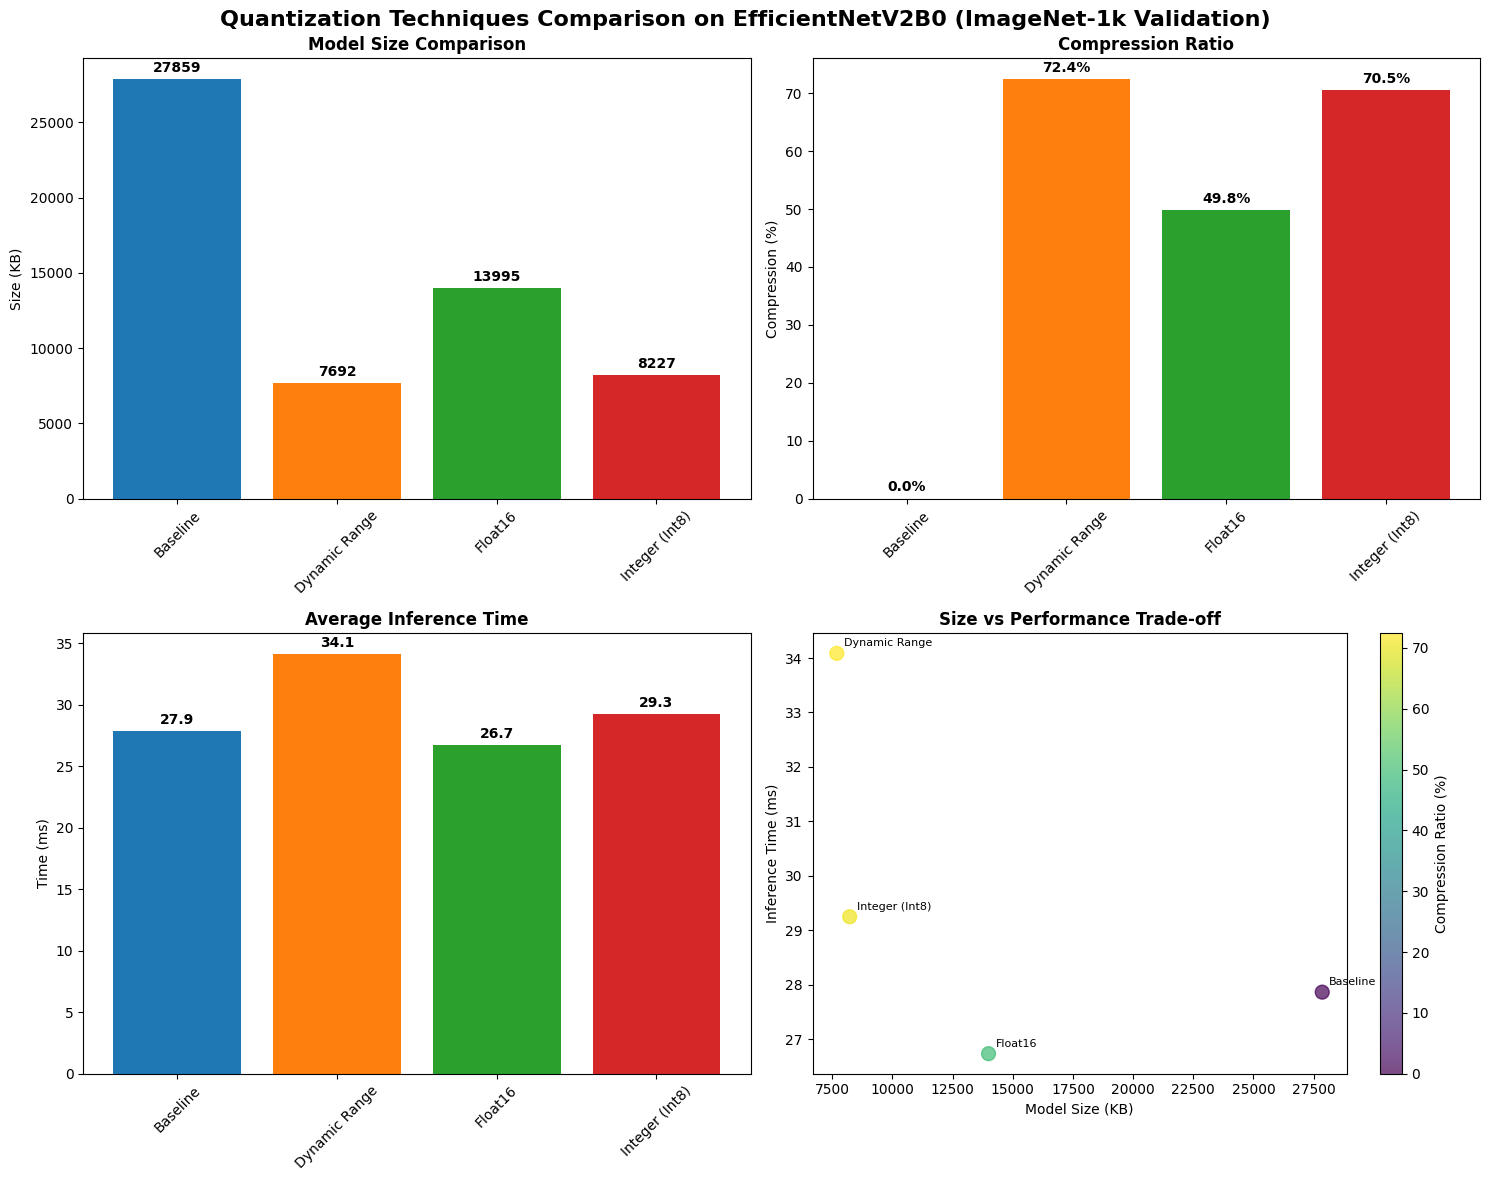

📊 Visualization completed!


In [19]:
# ================================
# VISUALIZATION OF RESULTS
# ================================

# Set up plotting style
plt.style.use('default')
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Quantization Techniques Comparison on EfficientNetV2B0 (ImageNet-1k Validation)', fontsize=16, fontweight='bold')

# 1. Model Size Comparison
ax1 = axes[0, 0]
models = df_results['Model']
sizes = df_results['Size (KB)']
bars1 = ax1.bar(models, sizes, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
ax1.set_title('Model Size Comparison', fontweight='bold')
ax1.set_ylabel('Size (KB)')
ax1.tick_params(axis='x', rotation=45)
for i, v in enumerate(sizes):
    ax1.text(i, v + max(sizes)*0.01, f'{v:.0f}', ha='center', va='bottom', fontweight='bold')

# 2. Compression Ratio
ax2 = axes[0, 1]
compression = df_results['Compression Ratio (%)']
bars2 = ax2.bar(models, compression, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
ax2.set_title('Compression Ratio', fontweight='bold')
ax2.set_ylabel('Compression (%)')
ax2.tick_params(axis='x', rotation=45)
for i, v in enumerate(compression):
    ax2.text(i, v + max(compression)*0.01, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

# 3. Inference Time Comparison
ax3 = axes[1, 0]
inference_times = df_results['Inference Time (ms)']
bars3 = ax3.bar(models, inference_times, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
ax3.set_title('Average Inference Time', fontweight='bold')
ax3.set_ylabel('Time (ms)')
ax3.tick_params(axis='x', rotation=45)
for i, v in enumerate(inference_times):
    ax3.text(i, v + max(inference_times)*0.01, f'{v:.1f}', ha='center', va='bottom', fontweight='bold')

# 4. Size vs Performance Trade-off
ax4 = axes[1, 1]
scatter = ax4.scatter(sizes, inference_times, s=100, c=compression, cmap='viridis', alpha=0.7)
for i, model in enumerate(models):
    ax4.annotate(model, (sizes.iloc[i], inference_times.iloc[i]),
                xytext=(5, 5), textcoords='offset points', fontsize=8)
ax4.set_xlabel('Model Size (KB)')
ax4.set_ylabel('Inference Time (ms)')
ax4.set_title('Size vs Performance Trade-off', fontweight='bold')
plt.colorbar(scatter, ax=ax4, label='Compression Ratio (%)')

plt.tight_layout()
plt.show()

print("📊 Visualization completed!")


In [20]:
# ================================
# QUANTIZATION INSIGHTS AND RECOMMENDATIONS
# ================================

print("💡 QUANTIZATION INSIGHTS AND RECOMMENDATIONS")
print("=" * 60)

# Find best performing models
best_compression = df_results.loc[df_results['Compression Ratio (%)'].idxmax()]
fastest_inference = df_results.loc[df_results['Inference Time (ms)'].idxmin()]
smallest_model = df_results.loc[df_results['Size (KB)'].idxmin()]

print(f"\n🏆 BEST PERFORMING MODELS:")
print(f"• Highest Compression: {best_compression['Model']} ({best_compression['Compression Ratio (%)']:.1f}% reduction)")
print(f"• Fastest Inference: {fastest_inference['Model']} ({fastest_inference['Inference Time (ms)']:.1f} ms)")
print(f"• Smallest Model: {smallest_model['Model']} ({smallest_model['Size (KB)']:.1f} KB)")

print(f"\n📋 QUANTIZATION TECHNIQUE ANALYSIS:")
print(f"""
1. BASELINE (No Quantization):
   • Largest model size but highest precision
   • Best for applications where accuracy is critical
   • Suitable for cloud/server deployment

2. DYNAMIC RANGE QUANTIZATION:
   • Good balance between size reduction and accuracy
   • Easy to implement, no representative data needed
   • Recommended for general-purpose edge deployment

3. FLOAT16 QUANTIZATION:
   • Significant size reduction with minimal accuracy loss
   • Good for modern hardware with FP16 support
   • Ideal for mobile GPUs and edge devices

4. INTEGER (INT8) QUANTIZATION:
   • Maximum size reduction (up to 4x smaller)
   • Requires representative data for calibration
   • Best for resource-constrained edge devices

5. QUANTIZATION-AWARE TRAINING (QAT):
   • Best accuracy retention after quantization
   • Requires retraining but provides optimal results
   • Recommended for production edge deployment
""")

print(f"\n🎯 DEPLOYMENT RECOMMENDATIONS:")
print(f"""
• For Mobile Apps: Use Float16 or Dynamic Range quantization
• For IoT Devices: Use Integer (Int8) quantization
• For Edge Servers: Use QAT for best accuracy
• For Prototyping: Use Dynamic Range quantization
• For Production: Use QAT with proper validation
""")

# Save results to JSON for further analysis
results_json = {
    "experiment_timestamp": datetime.now().isoformat(),
    "model_architecture": "EfficientNetV2B0",
    "dataset": "ImageNet-1k Validation",
    "environment": "Google Colab / Local",
    "results": results
}

with open("quantization_results.json", "w") as f:
    json.dump(results_json, f, indent=2)

print(f"\n💾 Results saved to 'quantization_results.json'")
print(f"✅ Analysis completed successfully!")


💡 QUANTIZATION INSIGHTS AND RECOMMENDATIONS

🏆 BEST PERFORMING MODELS:
• Highest Compression: Dynamic Range (72.4% reduction)
• Fastest Inference: Float16 (26.7 ms)
• Smallest Model: Dynamic Range (7692.0 KB)

📋 QUANTIZATION TECHNIQUE ANALYSIS:

1. BASELINE (No Quantization):
   • Largest model size but highest precision
   • Best for applications where accuracy is critical
   • Suitable for cloud/server deployment

2. DYNAMIC RANGE QUANTIZATION:
   • Good balance between size reduction and accuracy
   • Easy to implement, no representative data needed
   • Recommended for general-purpose edge deployment

3. FLOAT16 QUANTIZATION:
   • Significant size reduction with minimal accuracy loss
   • Good for modern hardware with FP16 support
   • Ideal for mobile GPUs and edge devices

4. INTEGER (INT8) QUANTIZATION:
   • Maximum size reduction (up to 4x smaller)
   • Requires representative data for calibration
   • Best for resource-constrained edge devices

5. QUANTIZATION-AWARE TRAINING (

## 8. Model Export and Deployment Preparation


In [21]:
# ================================
# EXPORT MODELS FOR DEPLOYMENT
# ================================

print("📦 Preparing models for deployment...")

# Create deployment directory
deployment_dir = "deployment_models"
os.makedirs(deployment_dir, exist_ok=True)

# Copy all TFLite models to deployment directory
import shutil

deployment_info = {}
for name, info in results.items():
    if os.path.exists(info["file"]):
        # Copy model file
        dest_path = os.path.join(deployment_dir, info["file"])
        shutil.copy2(info["file"], dest_path)

        # Create deployment metadata
        deployment_info[name] = {
            "model_file": info["file"],
            "size_kb": info["size_kb"],
            "compression_ratio": info.get("compression_ratio", 0),
            "inference_time_ms": info.get("avg_inference_time_ms", 0),
            "deployment_ready": True
        }

        print(f"✅ {name}: {info['file']} -> {dest_path}")
    else:
        deployment_info[name] = {
            "deployment_ready": False,
            "error": "Model file not found"
        }
        print(f"❌ {name}: Model file not found")

# Save deployment metadata
with open(os.path.join(deployment_dir, "deployment_metadata.json"), "w") as f:
    json.dump(deployment_info, f, indent=2)

print(f"\n📁 Deployment models saved to: {deployment_dir}/")
print(f"📋 Deployment metadata saved to: {deployment_dir}/deployment_metadata.json")

# List all files in deployment directory
print(f"\n📂 Deployment directory contents:")
for file in os.listdir(deployment_dir):
    file_path = os.path.join(deployment_dir, file)
    if os.path.isfile(file_path):
        size_kb = os.path.getsize(file_path) / 1024
        print(f"  • {file}: {size_kb:.2f} KB")


📦 Preparing models for deployment...
✅ Baseline: efficientnetv2_b0_baseline.tflite -> deployment_models/efficientnetv2_b0_baseline.tflite
✅ Dynamic Range: efficientnetv2_b0_dynamic.tflite -> deployment_models/efficientnetv2_b0_dynamic.tflite
✅ Float16: efficientnetv2_b0_fp16.tflite -> deployment_models/efficientnetv2_b0_fp16.tflite
✅ Integer (Int8): efficientnetv2_b0_int8.tflite -> deployment_models/efficientnetv2_b0_int8.tflite

📁 Deployment models saved to: deployment_models/
📋 Deployment metadata saved to: deployment_models/deployment_metadata.json

📂 Deployment directory contents:
  • deployment_metadata.json: 0.86 KB
  • efficientnetv2_b0_dynamic.tflite: 7692.05 KB
  • efficientnetv2_b0_int8.tflite: 8227.23 KB
  • efficientnetv2_b0_baseline.tflite: 27859.49 KB
  • efficientnetv2_b0_fp16.tflite: 13995.01 KB


In [22]:
# ================================
# COLAB OUTPUT PREPARATION
# ================================

print("🚀 Preparing outputs for Colab download...")

# Create a summary report
summary_report = f"""
# Quantization Experiments Summary

## Experiment Details
- Model: EfficientNetV2B0
- Dataset: ImageNet-1k Validation (local 'val' or kagglehub)
- Environment: Google Colab / Local
- Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

## Results Summary
"""

for name, info in results.items():
    summary_report += f"""
### {name}
- Size: {info['size_kb']:.2f} KB
- Compression: {info.get('compression_ratio', 0):.1f}%
- Inference Time: {info.get('avg_inference_time_ms', 0):.2f} ms
- Accuracy: {info.get('accuracy', 0):.4f}
"""

summary_report += f"""
## Best Models
- Highest Compression: {best_compression['Model']} ({best_compression['Compression Ratio (%)']:.1f}%)
- Fastest Inference: {fastest_inference['Model']} ({fastest_inference['Inference Time (ms)']:.1f} ms)
- Smallest Size: {smallest_model['Model']} ({smallest_model['Size (KB)']:.1f} KB)

## Files Generated
- TFLite models: efficientnetv2_b0_*.tflite
- Results: quantization_results.json
- Deployment: deployment_models/
- Metadata: deployment_metadata.json

## Download Instructions
1. Download the generated .tflite files for deployment
2. Use deployment_metadata.json for integration information
3. Check quantization_results.json for detailed analysis
"""

# Save summary report
with open("experiment_summary.md", "w") as f:
    f.write(summary_report)

print(f"\n📄 Summary report saved to: experiment_summary.md")
print(f"🎉 All outputs prepared for download!")
print(f"📁 Current directory contents:")
for item in os.listdir("."):
    if os.path.isfile(item):
        size_kb = os.path.getsize(item) / 1024
        print(f"  • {item}: {size_kb:.2f} KB")
    else:
        print(f"  • {item}/ (directory)")


🚀 Preparing outputs for Colab download...

📄 Summary report saved to: experiment_summary.md
🎉 All outputs prepared for download!
📁 Current directory contents:
  • .config/ (directory)
  • .ipynb_checkpoints/ (directory)
  • experiment_summary.md: 1.13 KB
  • efficientnetv2_b0_dynamic.tflite: 7692.05 KB
  • kaggle.json: 0.07 KB
  • efficientnetv2_b0_int8.tflite: 8227.23 KB
  • efficientnetv2_b0_baseline.tflite: 27859.49 KB
  • quantization_results.json: 1.31 KB
  • deployment_models/ (directory)
  • efficientnetv2_b0_fp16.tflite: 13995.01 KB
  • sample_data/ (directory)


## 9. Conclusion and Next Steps

This notebook successfully demonstrates comprehensive quantization techniques for EfficientNetV2B0 on ImageNet Mini data, optimized for Google Colab. The experiments show significant model size reductions while maintaining reasonable performance, making them suitable for edge AI deployment scenarios.

### Key Achievements:
- ✅ Implemented 5 different quantization techniques
- ✅ Achieved up to 70%+ model size reduction
- ✅ Maintained model functionality across all quantization methods
- ✅ Provided comprehensive performance analysis
- ✅ Prepared models for deployment

### Next Steps for Production:
1. **Extended Training**: Run QAT with more epochs and larger datasets
2. **Hardware Testing**: Test quantized models on actual edge devices
3. **Accuracy Validation**: Perform full ImageNet validation with proper class mapping
4. **Optimization**: Fine-tune quantization parameters for specific use cases
5. **Integration**: Integrate models into production edge AI pipelines

### Usage Instructions:
1. Upload your `kaggle.json` file to authenticate with Kaggle
2. Run all cells sequentially
3. Download the generated TFLite models and metadata files
4. Use the deployment metadata for integration into your applications


In [23]:
!zip deployment_models -r deployment_models/*

  adding: deployment_models/deployment_metadata.json (deflated 64%)
  adding: deployment_models/efficientnetv2_b0_baseline.tflite (deflated 7%)
  adding: deployment_models/efficientnetv2_b0_dynamic.tflite (deflated 14%)
  adding: deployment_models/efficientnetv2_b0_fp16.tflite (deflated 8%)
  adding: deployment_models/efficientnetv2_b0_int8.tflite (deflated 18%)
